In [22]:
# Import relevant modules
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#import scipy.stats
import tensorflow_probability as tfp

In [109]:
# Parameters
expiry = 1.5
spot = 100.0
vol = 0.20
rate = 0.04
div = 0.01
strike = 100.0

# Bumps for differentials
spot_bump = 0.01  # Percentage of spot
vol_bump = 0.01  # Percentage of vol
time_bump = 1.0 / 365.0

# Scalings
vega_scaling = 0.01  # Vega shown for 1% absolute move
theta_scaling = 1.0 / 365.0  # Theta shown for 1d move

seed = 42
verbose = False

In [129]:
# Closed-forms
# N = tf.compat.v1.distributions.Normal(0.0, 1.1)
N = tfp.distributions.Normal(0.0, 1.0)
# # N = scipy.stats.norm.cdf

def black_price(f, k, s, t, is_call):
#     w = 1.0 if is_call else -1.0
    stdev = s * tf.math.sqrt(t)
    d1 = tf.math.log(f / k) / stdev + 0.5 * stdev
#     d2 = d1 - stdev
    return (f - k) * N.cdf(d1)
#     return w * (f * N.cdf(w * d1) - k * N.cdf(w * d2))


In [130]:
# Standard simulator
def simulate_std(spot_, vol_, time_, gaussians, debug=False):
    # Calculate deterministic forward
    fwd = spot_ * np.exp((rate - div) * time_)

    # Calculate final spot paths
    stdev = vol_ * np.sqrt(time_)
    future_spot = fwd * np.exp(-0.5 * stdev * stdev + stdev * gaussians)
    future_spot = future_spot[:, 0]
    
    # Calculate discounted payoff
    df = np.exp(-rate * time_)
    payoff = [df * max(s - strike, 0) for s in future_spot]
    
    # Reduce
    pv = np.mean(payoff)
    
    if debug:
        print(future_spot)
        print(payoff)

    return pv

In [131]:
# Calculation by bumps
def calculate_bumps(spot_, vol_, time_, num_mc, redraw, debug=False):
    rng = np.random.RandomState(seed)
    gaussians = rng.normal(0.0, 1.0, (num_mc, 1))

    pv = simulate_std(spot_, vol_, expiry, gaussians, debug)

    if redraw:
        gaussians = rng.normal(0.0, 1.0, (num_mc, 1))
    pv_spot_up = simulate_std(spot_ * (1.0 + spot_bump), vol_, time_, gaussians, debug)

    if redraw:
        gaussians = rng.normal(0.0, 1.0, (num_mc, 1))
    pv_spot_down = simulate_std(spot_ * (1.0 - spot_bump), vol_, time_, gaussians, debug)

    if redraw:
        gaussians = rng.normal(0.0, 1.0, (num_mc, 1))
    pv_vol_up = simulate_std(spot_, vol_ * (1.0 + vol_bump), time_, gaussians, debug)

    if redraw:
        gaussians = rng.normal(0.0, 1.0, (num_mc, 1))
    pv_vol_down = simulate_std(spot_, vol_ * (1.0 - vol_bump), time_, gaussians, debug)

    if redraw:
        gaussians = rng.normal(0.0, 1.0, (num_mc, 1))
    pv_expiry_down = simulate_std(spot_, vol_, time_ - time_bump, gaussians, debug)

    delta = (pv_spot_up - pv_spot_down) / (2.0 * spot_bump * spot_)
    gamma = (pv_spot_up + pv_spot_down - 2.0 * pv) / (np.power(spot_bump * spot_, 2))
    vega = (pv_vol_up - pv_vol_down) / (2.0 * vol_bump * vol_) * vega_scaling 
    theta = (pv_expiry_down - pv) / time_bump * theta_scaling
          
    return pv, delta, gamma, vega, theta

In [132]:
# Test bumps
redraw = False
num_mc = 1000000
pv, delta, gamma, vega, theta = calculate_bumps(spot, vol, expiry, num_mc, redraw, verbose)

print("PV: {:,.4f}".format(pv))
print("Delta: {:,.4f}".format(delta))
print("Gamma: {:,.4f}".format(gamma))
print("Vega: {:,.4f}".format(vega))
print("Theta: {:,.4f}".format(theta))

PV: 11.6965
Delta: 0.6104
Gamma: 0.0152
Vega: 0.4582
Theta: -0.0121


In [133]:
# AAD 1st order simulator
def simulate_aad_1st(spot_, vol_, time_, gaussians, debug=False):
    tf_spot = tf.convert_to_tensor(spot_, dtype='float32')
    tf_vol = tf.convert_to_tensor(vol_)
    tf_time = tf.convert_to_tensor(time_)
    tf_rate = tf.constant(rate)
    tf_div = tf.constant(div)
  
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([tf_spot, tf_vol, tf_time])
        
        # Calculate deterministic forward
        fwd = tf_spot * tf.math.exp((tf_rate - tf_div) * tf_time)

        # Calculate final spot paths
        stdev = tf_vol * tf.math.sqrt(tf_time)
        future_spot = fwd * tf.math.exp(-0.5 * stdev * stdev + stdev * gaussians)
        future_spot = future_spot[:, 0]

        # Calculate discounted payoff
        df = tf.math.exp(-tf_rate * tf_time)
        payoff = df * tf.math.maximum(future_spot - strike, 0.0)

        # Reduce
        pv = tf.reduce_mean(payoff)
       
    delta = tape.gradient(pv, tf_spot)
    vega = tape.gradient(pv, tf_vol)
    theta = tape.gradient(pv, tf_time)
    
    return pv.numpy(), delta.numpy(), vega.numpy() * vega_scaling, -theta.numpy() * theta_scaling

In [134]:
# AAD 2nd order simulator with bumps
def calculate_aad_bump(spot_, vol_, time_, num_mc, debug=False):
    rng = np.random.RandomState(seed)
    gaussians = rng.normal(0.0, 1.0, (num_mc, 1))
    
    # Get pv and 1st order Greeks
    pv, delta, vega, theta = simulate_aad_1st(spot_, vol_, time_, gaussians, debug)
    
    # Bump spot
    spot_up_ = spot_ * (1.0 + spot_bump)
    pv_up, delta_up, vega_up, theta_up = simulate_aad_1st(spot_up_, vol_, time_, gaussians, debug)
    
    # Bump spot down
    spot_down_ = spot_ * (1.0 - spot_bump)
    pv_down, delta_down, vega_down, theta_down = simulate_aad_1st(spot_down_, vol_, time_, gaussians, debug)
    
    # Calculate gamma
    gamma = (delta_up - delta_down) / (2.0 * spot_ * spot_bump)
    
    return pv, delta, gamma, vega, theta

In [135]:
# Test AAD by bumping
num_mc = 1000000

pv, delta, gamma, vega, theta = calculate_aad_bump(spot, vol, expiry, num_mc, debug=verbose)

print("PV: {:,.4f}".format(pv))
print("Delta: {:,.4f}".format(delta))
print("Gamma: {:,.4f}".format(gamma))
print("Vega: {:,.4f}".format(vega))
print("Theta: {:,.4f}".format(theta))

PV: 11.6965
Delta: 0.6105
Gamma: 0.0152
Vega: 0.4582
Theta: -0.0121


In [151]:
# AAD 2nd order simulator with smoothing
epsilon = 1e-1
smooth_vol = 0.30
smooth_time = 10.0 / 365.0


def smooth_max(future_spot, strike):
#     payoff = future_spot - strike
#     payoff = 0.5 * (payoff + tf.math.sqrt(tf.math.pow(payoff, 2) + epsilon))
    payoff = black_price(future_spot, strike, smooth_vol, smooth_time, True)
    
    return payoff

def calculate_aad_smooth(spot_, vol_, time_, num_mc, debug=False):
    rng = np.random.RandomState(seed)
    gaussians = rng.normal(0.0, 1.0, (num_mc, 1))

    tf_spot = tf.convert_to_tensor(spot_, dtype='float32')
    tf_vol = tf.convert_to_tensor(vol_)
    tf_time = tf.convert_to_tensor(time_)
    tf_rate = tf.constant(rate)
    tf_div = tf.constant(div)
  
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([tf_spot, tf_vol, tf_time])
        with tf.GradientTape() as gamma_tape:
            gamma_tape.watch(tf_spot)

            # Calculate deterministic forward
            fwd = tf_spot * tf.math.exp((tf_rate - tf_div) * tf_time)

            # Calculate final spot paths
            stdev = tf_vol * tf.math.sqrt(tf_time)
            future_spot = fwd * tf.math.exp(-0.5 * stdev * stdev + stdev * gaussians)
            future_spot = future_spot[:, 0]

            # Calculate discounted payoff
            df = tf.math.exp(-tf_rate * tf_time)
#             payoff = df * (future_spot - strike)
            # Use smooth max function
#             payoff = smooth_max(payoff)
            payoff = df * smooth_max(future_spot , strike)

            # Reduce
            pv = tf.reduce_mean(payoff)

        # Calculate delta
        g_delta = gamma_tape.gradient(pv, tf_spot)
       
    delta = tape.gradient(pv, tf_spot)
    gamma = tape.gradient(g_delta, tf_spot)
    vega = tape.gradient(pv, tf_vol)
    theta = tape.gradient(pv, tf_time)
    
    return pv.numpy(), delta.numpy(), gamma.numpy(), vega.numpy() * vega_scaling, -theta.numpy() * theta_scaling

In [152]:
# Test AAD by smoothing
num_mc = 1000000

pv, delta, gamma, vega, theta = calculate_aad_smooth(spot, vol, expiry, num_mc)

print("PV: {:,.4f}".format(pv))
print("Delta: {:,.4f}".format(delta))
print("Gamma: {:,.4f}".format(gamma))
print("Vega: {:,.4f}".format(vega))
print("Theta: {:,.4f}".format(theta))

PV: 11.5135
Delta: 0.6108
Gamma: 0.0156
Vega: 0.4667
Theta: -0.0123


In [149]:
# Ladder tests
num_points = 100
spot_ladder = np.linspace(20.0, 200.0, num_points, dtype='double')
num_mc = 5000

# Test method 1
print("Calculating with Method 1...")
pv_m1 = []
delta_m1 = []
gamma_m1 = []
vega_m1 = []
theta_m1 = []
for i in range(len(spot_ladder)):
    pv, delta, gamma, vega, theta = calculate_bumps(spot_ladder[i], vol, expiry, num_mc, redraw=False)
#     pv, delta, gamma, vega, theta = calculate_bumps(spot_ladder[i], vol, expiry, num_mc, redraw=True)
    pv_m1.append(pv)
    delta_m1.append(delta)
    gamma_m1.append(gamma)
    vega_m1.append(vega)
    theta_m1.append(theta)

# Test method 2
print("Calculating with Method 2...")
pv_m2 = []
delta_m2 = []
gamma_m2 = []
vega_m2 = []
theta_m2 = []
for i in range(len(spot_ladder)):
    pv, delta, gamma, vega, theta = calculate_aad_bump(spot_ladder[i], vol, expiry, num_mc)
#     pv, delta, gamma, vega, theta = calculate_bumps(spot_ladder[i], vol, expiry, num_mc, redraw=False)
    pv_m2.append(pv)
    delta_m2.append(delta)
    gamma_m2.append(gamma)
    vega_m2.append(vega)
    theta_m2.append(theta)

# Test method 3
print("Calculating with Method 3...")
pv_m3 = []
delta_m3 = []
gamma_m3 = []
vega_m3 = []
theta_m3 = []
for i in range(len(spot_ladder)):
    pv, delta, gamma, vega, theta = calculate_aad_smooth(spot_ladder[i], vol, expiry, num_mc)
    pv_m3.append(pv)
    delta_m3.append(delta)
    gamma_m3.append(gamma)
    vega_m3.append(vega)
    theta_m3.append(theta)

print("Calculation complete!")

Calculating with Method 1...
Calculating with Method 2...
Calculating with Method 3...
Calculation complete!


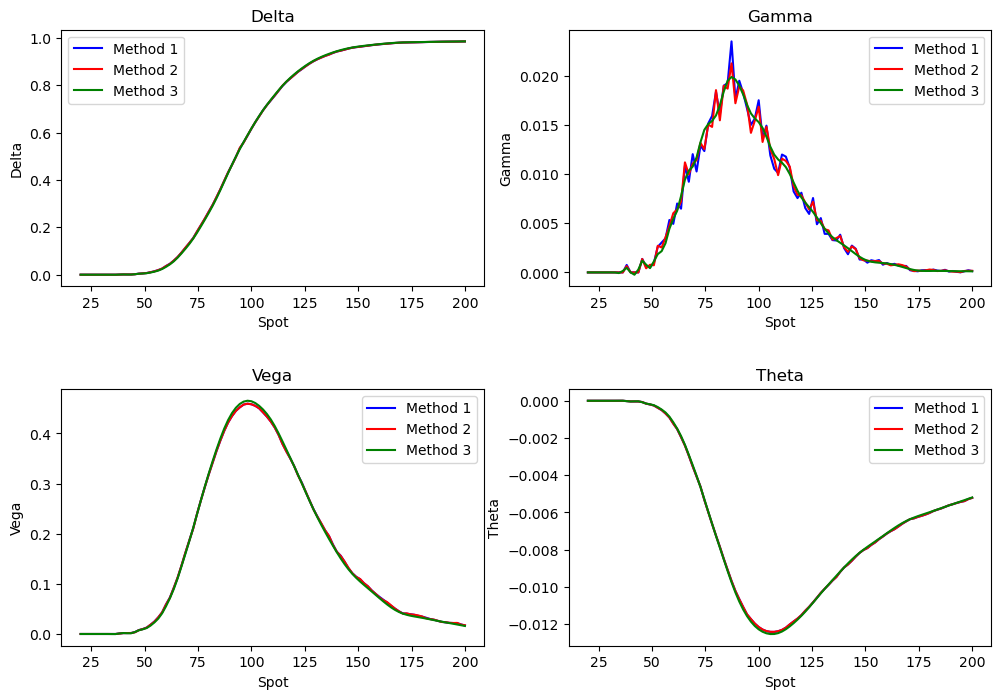

In [150]:
# Plot results
plt.ioff()
plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=0.40)

# Delta
plt.subplot(2, 2, 1)
plt.title("Delta")
plt.xlabel('Spot')
plt.ylabel('Delta')
plt.plot(spot_ladder, delta_m1, color='blue', label='Method 1')
plt.plot(spot_ladder, delta_m2, color='red', label='Method 2')
plt.plot(spot_ladder, delta_m3, color='green', label='Method 3')
plt.legend(loc='upper left')

# Gamma
plt.subplot(2, 2, 2)
plt.title("Gamma")
plt.xlabel('Spot')
plt.ylabel('Gamma')
plt.plot(spot_ladder, gamma_m1, color='blue', label='Method 1')
plt.plot(spot_ladder, gamma_m2, color='red', label='Method 2')
plt.plot(spot_ladder, gamma_m3, color='green', label='Method 3')
plt.legend(loc='upper right')

# Vega
plt.subplot(2, 2, 3)
plt.title("Vega")
plt.xlabel('Spot')
plt.ylabel('Vega')
plt.plot(spot_ladder, vega_m1, color='blue', label='Method 1')
plt.plot(spot_ladder, vega_m2, color='red', label='Method 2')
plt.plot(spot_ladder, vega_m3, color='green', label='Method 3')
plt.legend(loc='upper right')

# Theta
plt.subplot(2, 2, 4)
plt.title("Theta")
plt.xlabel('Spot')
plt.ylabel('Theta')
plt.plot(spot_ladder, theta_m1, color='blue', label='Method 1')
plt.plot(spot_ladder, theta_m2, color='red', label='Method 2')
plt.plot(spot_ladder, theta_m3, color='green', label='Method 3')
plt.legend(loc='upper right')

plt.show()